In [1]:
import numpy as np
import pandas as pd
import pickle

from matplotlib.gridspec import GridSpec

from matplotlib import pyplot as plt

import hist
import scipy
from scipy import optimize

In [2]:
datadir = "/home/chardong/y_identification/Venv/save_pkl/df_test_sample_hard_scattering/"
savedir = "/home/chardong/y_identification/Venv/save_plots/"

In [3]:
df = pd.read_pickle(datadir+"df_test_combined_sample_hard_scattering_skim30.pkl")
#df.head()

In [4]:
# Preselection on photon passin Loose cut-based selection 
df = df.query('y_IsLoose == 1')

In [5]:
# Adding column with absolute eta value, assuming symmetry
df['y_abs_eta'] = np.abs(df['y_eta'])
#df.head()

### Edges of bins

In [6]:
# y_pt
edges_pt_bkg = [ 20.,  25.,  30.,  35.,  40.,  45., 50., 55., 65., 80., 490. ]
edges_pt_sig = [ 20.,    25.,    30.,    35.,    40.,
                 45.,    50.,    55.,    60.,    65.,    
                 70.,    75.,    80.,    85.,    90.,
                 95.,   100.,   110.,   120.,   140.,   
                145.,   150.,   155.,   160.,   165.,
                175.,   190.,   205.,   230.,   280.,   
                285.,   290.,   300.,   305.,   315.,
                325.,   340.,   355.,   370.,   395.,   
                430.,   490.]
# y_eta
edges_eta = [0 , 0.4 ,  0.6  ,  0.8  ,  1.15  ,  1.37  , 1.52 ,  1.81  ,  2.01  ,  2.37,  2.45 ]

# Créer des axes de structure de bins
axis_pt_sig = hist.axis.Variable(edges_pt_sig, name='pt', label=r"$p_T$ [GeV]")
axis_pt_bkg = hist.axis.Variable(edges_pt_bkg, name='pt', label=r"$p_T$ [GeV]")

# Créer des axes de structure de bins
axis_eta  = hist.axis.Variable(edges_eta, name="eta", label=r"$\eta$")

# Nouvelles colones pt_bin_.. dans le df assignant chaque valeur de y_abs_eta à un bin de l'histograme axis_... 
df = df.assign(pt_bin_sig=axis_pt_sig.index(df['y_pt']))
df = df.assign(pt_bin_bkg=axis_pt_bkg.index(df['y_pt']))

# Nouvelles colones eta_bin_.. dans le df assignant chaque valeur de y_abs_eta à un bin de l'histograme axis_... 
df = df.assign(eta_bin=axis_eta.index(df['y_abs_eta']))

### Filter and tight selection

In [7]:
df_sig = df.query('truth_label==1')
df_bkg = df.query('truth_label==0')

df_sig_tight = df_sig[(df_sig["y_IsTight"]==1)]  #bouléen
df_bkg_tight = df_bkg[(df_bkg["y_IsTight"]==1)]

### Compute efficiency and rejection for cut-based Tight identification

In [8]:
# Histograms and Axes pour `mu` et 'eta'
den_sig = hist.Hist(axis_eta, axis_pt_sig).fill(df_sig["y_abs_eta"], df_sig["y_pt"])   #before cut-base
den_bkg = hist.Hist(axis_eta, axis_pt_bkg).fill(df_bkg["y_abs_eta"], df_bkg["y_pt"])

num_sig_tight = hist.Hist(axis_eta, axis_pt_sig).fill(df_sig_tight["y_abs_eta"], df_sig_tight["y_pt"])   #after cut-base
num_bkg_tight = hist.Hist(axis_eta, axis_pt_bkg).fill(df_bkg_tight["y_abs_eta"], df_bkg_tight["y_pt"])

In [9]:
# Integration over 'pt' axis
den_sig_integrated = den_sig.project("eta")  # Summing over pt axis
num_sig_tight_integrated = num_sig_tight.project("eta")

# Efficiency and Error Calculation
eff_sig_tight_integrated = num_sig_tight_integrated / den_sig_integrated
efferr_values_sig = np.sqrt(eff_sig_tight_integrated.values() * 
                            (1. - eff_sig_tight_integrated.values()) / den_sig_integrated.values())

rjct_bkg_tight_integrated = 1. - eff_sig_tight_integrated.values()
rjcterr_values_bkg = efferr_values_sig  # Errors are the same as for efficiency


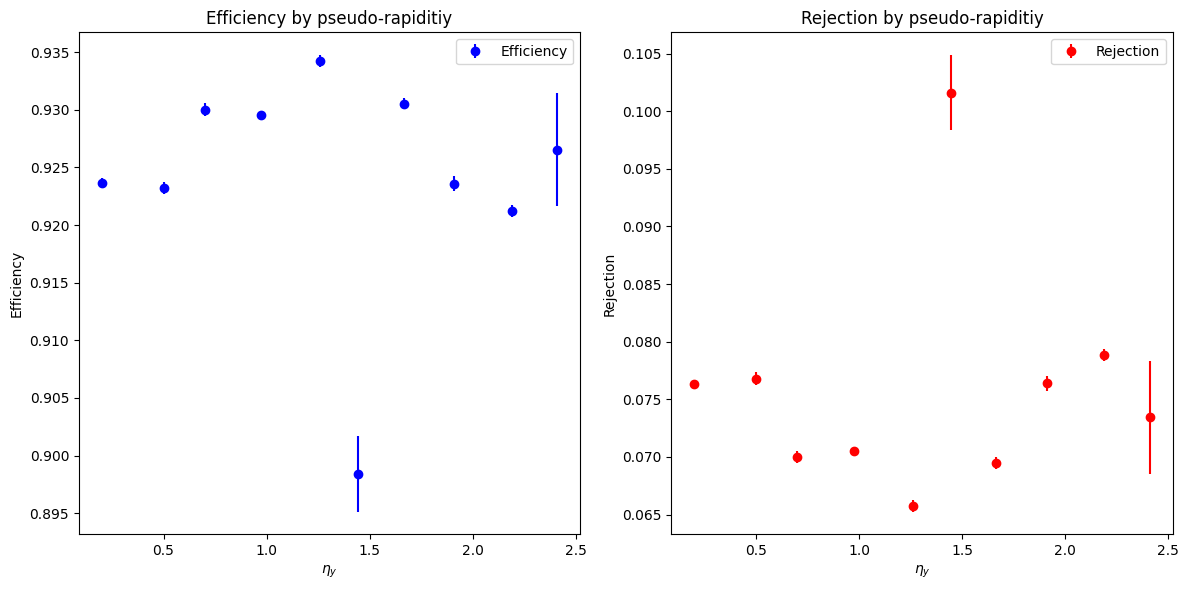

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Efficiency plot
ax[0].errorbar(den_sig_integrated.axes[0].centers, eff_sig_tight_integrated.values(), yerr=efferr_values_sig, 
               fmt='o', label='Efficiency', color='blue')
ax[0].set_title("Efficiency by pseudo-rapiditiy")
ax[0].set_xlabel("$\eta_y$")
ax[0].set_ylabel("Efficiency")
ax[0].legend()

# Rejection plot
ax[1].errorbar(den_sig_integrated.axes[0].centers, rjct_bkg_tight_integrated, yerr=rjcterr_values_bkg, 
               fmt='o', label='Rejection', color='red')
ax[1].set_title("Rejection by pseudo-rapiditiy")
ax[1].set_xlabel("$\eta_y$")
ax[1].set_ylabel("Rejection")
ax[1].legend()

plt.tight_layout()
plt.show()

In [11]:
def compute_tight(num, den):
    """Calculate the sum of num and den histograms, and compute efficiency and its binomial uncertainty."""
    eff = num / den
    efferr = np.sqrt(eff * (1. - eff) / den)
    return eff, efferr

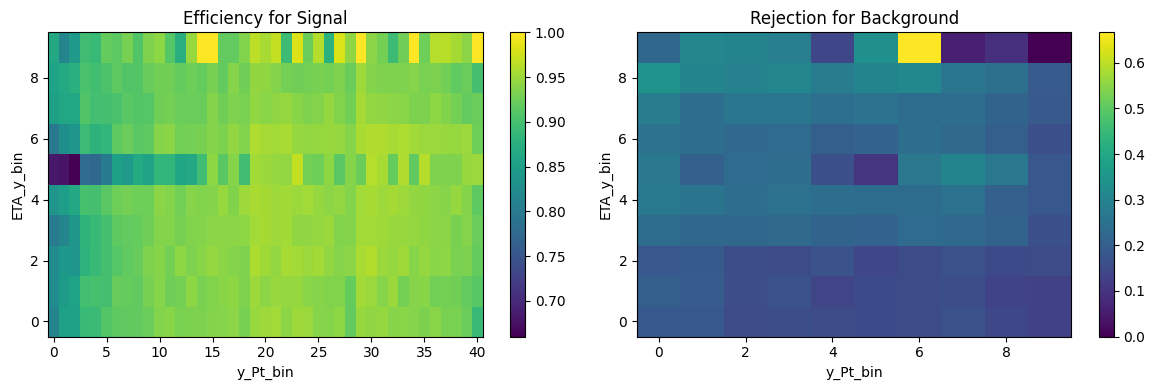

In [12]:
# Histograms for Signal
eff_sig_2Darray, efferr_sig_2Darray = compute_tight(num_sig_tight.values(), den_sig.values())
# Histograms for Background
eff_bkg_2Darray, efferr_bkg_2Darray = compute_tight(num_bkg_tight.values(), den_bkg.values())


# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# function imshow (of Matplotlib) displays data as an image, i.e., on a 2D matrix.

# Plotting "plot collection" efficiency for signal
pc_sig = ax[0].imshow(eff_sig_2Darray, aspect='auto', origin='lower') # 'auto' : pixels are automatically adjusted 
                                                                        # to fill the axes area
fig.colorbar(pc_sig, ax=ax[0])
ax[0].set_title("Efficiency for Signal")
ax[0].set_xlabel("y_Pt_bin")
ax[0].set_ylabel("ETA_y_bin")

# Plotting efficiency for background
pc_bkg = ax[1].imshow(eff_bkg_2Darray, aspect='auto', origin='lower')

fig.colorbar(pc_bkg, ax=ax[1])
ax[1].set_title("Rejection for Background")
ax[1].set_xlabel("y_Pt_bin")
ax[1].set_ylabel("ETA_y_bin")



plt.tight_layout()
#plt.savefig(savedir+"BDT_PID_reject_effi/Heatmap_efficiency_ETA_Bin_pT.pdf")

plt.show()


## New definition of eff_sig & eff_bkg NO integrated over pT axis.

In [13]:
eff_sig_tight = (num_sig_tight/den_sig).values()
efferr_sig_tight = np.sqrt(eff_sig_tight*(1.-eff_sig_tight)/den_sig.values()) # binomial uncertainty on efficiency

eff_bkg_tight = (num_bkg_tight/den_bkg).values()
efferr_bkg_tight = np.sqrt(eff_bkg_tight*(1.-eff_bkg_tight)/den_bkg.values()) # binomial uncertainty on efficiency


In [14]:
print(len(eff_sig_tight))
print(len(eff_sig_tight[0]))

10
41


# BDT working point optimization
Optimiser le point de fonctionnement d'un modèle BDT (Boosted Decision Trees) en calculant un seuil de score qui atteint une efficacité cible donnée.

In [15]:
def compute_eff_BDT(df, threshold):
    '''Return efficienty of a given selection on BDT score'''
    r = (df['Original_signal_score'] > threshold).sum() / len(df) # 'threshold' -> Le seuil du score BDT utilisé pour déterminer 
                                                                    # si un événement est sélectionné.

#  (df['Addevtmu_signal_score'] > threshold) : 
#  Crée une série booléenne où chaque élément est True si le Addevtmu_signal_score de l'événement correspondant est supérieur au seuil donné,
#  sinon False.
#  .sum() : 
#  Compte le nombre de True dans la série booléenne, ce qui équivaut au nombre d'événements passant le seuil.
#  /len(df) : 
#  Pour obtenir l'efficacité de la sélection.  
    
    return r   # Efficacité de la sélection.

Trouve le seuil de score BDT qui permet d'atteindre une efficacité cible spécifique:

In [16]:
def find_cut_with_root_scalar(df, target_efficiency):
    '''Find selection on BDT score correponsing to target effeciency'''
    
#  scipy.optimize.root_scalar(....) :
#  Fonction de SciPy qui cherche une racine d'une fonction univariée. Ici, elle cherche le seuil x où l'efficacité de 
#  sélection est égale à l'efficacité cible.  

#  i.e: On veut lambda(x) = 0 
    
    r = scipy.optimize.root_scalar(                
        lambda x: compute_eff_BDT(df, x) - target_efficiency, bracket=(0., 1.0), # 'bracket' :  Scores BDT normalisés entre 0 et 1.
        
#  lambda x: compute_eff_BDT(df, x) - target_efficiency :
#  Fonction anonyme (lambda) qui calcule la différence entre l'efficacité obtenue pour un seuil donné x et l'efficacité cible. 
#  Cette fonction est utilisée pour trouver la racine (c'est-à-dire le seuil où la différence est zéro).
        
        method='brenth', options={'xtol': 1E-5, 'maxiter': 50}
    )

#  method='brenth' : 
#  méthode sécurisée qui combine la méthode de la bissection, la méthode des cordes et l'inversion quadratique.
    
#  'xtol': 1E-5, 'maxiter': 50 :
#   Définit la tolérance sur la solution (précision) et le nombre maximum d'itérations pour trouver la racine. 
    
    return r.root

# r.root est l'attribut de l'objet résultat retourné par root_scalar contenant la solution trouvée.

In [17]:
df_bkg.head()

,y_pt,y_eta,y_phi,y_convRadius,y_convType,weight,truth_label,evt_mu,y_IsLoose,y_IsTight,y_truth_pt,y_truth_eta,Original_background_score,Original_signal_score,Addevtmu_background_score,Addevtmu_signal_score,y_abs_eta,pt_bin_sig,pt_bin_bkg,eta_bin
13,52.215450,0.243938,3.000969,591.247253,2,1356.690078,0.0,26.49,True,False,49.477310,0.244247,0.139582,0.860418,0.130626,0.869374,0.243938,6,6,0
15,23.446785,-0.280572,-0.175317,603.915894,2,0.000000,0.0,88.50,True,False,6.954697,-0.348710,0.325843,0.674157,0.291422,0.708578,0.280572,0,0,0
19,27.264006,1.023548,0.111785,9999.000000,0,2646.182950,0.0,41.50,True,False,17.450459,1.023627,0.591846,0.408154,0.614341,0.385659,1.023548,1,1,3
50,24.273174,0.944408,-1.606246,9999.000000,0,4821.013393,0.0,24.50,True,False,17.278706,0.956865,0.755880,0.244120,0.776214,0.223786,0.944408,0,0,3
58,29.589968,-2.074576,0.171506,9999.000000,0,971.323793,0.0,29.50,True,False,21.993706,-2.104185,0.864590,0.135410,0.887825,0.112175,2.074576,1,1,8


## Objectif : trouver et stocker les seuils optimaux de BDT pour chaque bin de pT et ETA afin de maintenir la même efficacité de fond que la coupure tight.

In [18]:
# 'sort_index()' : Trie le DataFrame par ces index pour améliorer l'efficacité des opérations de recherche.
df_bkg_indexed = df_bkg.set_index(['pt_bin_bkg', 'eta_bin']).sort_index()

In [19]:
bdt_cut_same_background_efficiency_tight = {} # store optimal BDT thresholds


#    np.ndenumerate(eff_bkg_tight):  Itère sur chaque élément de eff_bkg_tight, une matrice d'efficacité tight pour le fond. 
#    Renvoie les indices (ieta, ipt) et la valeur eff_tight pour chaque bin.

for (ieta, ipt), eff_tight in np.ndenumerate(eff_bkg_tight): 
#   select subsample of events corresponding to the current (eta,pT) bin
    
    df_bin = df_bkg_indexed.loc[ipt, ieta] # using indexed df to speedup selection
    
#   find and store optimal BDT selection for current bin
    cut_BDT = find_cut_with_root_scalar(df_bin, target_efficiency=eff_tight)

#   Stocke le seuil de BDT trouvé dans le dictionnaire en utilisant (ipt, ieta) comme clé.   
    bdt_cut_same_background_efficiency_tight[ipt, ieta] = cut_BDT

bdt_cut_same_background_efficiency_tight = pd.Series(bdt_cut_same_background_efficiency_tight).sort_index() # Conversion en série pandas 
bdt_cut_same_background_efficiency_tight.index.names = ['pt_bin_bkg', 'eta_bin'] # Attribue des noms aux index de la Série

bdt_cut_same_background_efficiency_tight

pt_bin_bkg  eta_bin
0           0          0.776100
            1          0.759803
            2          0.762030
            3          0.773302
            4          0.707726
                         ...   
9           5          0.761755
            6          0.667421
            7          0.821173
            8          0.770525
            9          1.000000
Length: 100, dtype: float64

In [20]:
#  Renome puis fusionne la Série contenant les seuils de BDT avec le DataFrame df 
#  en utilisant les colonnes pt_bin_bkg et eta_bin comme clés de fusion. 
df = df.merge(bdt_cut_same_background_efficiency_tight.rename('BDTcut_samebkgeff_tight'), 
             on=['pt_bin_bkg', 'eta_bin'], how="left")

df = df.assign(pass_BDTcut_samebkgeff_tight = df['Original_signal_score'] > df['BDTcut_samebkgeff_tight'])

In [21]:
df.head()

,y_pt,y_eta,y_phi,y_convRadius,y_convType,weight,truth_label,evt_mu,y_IsLoose,y_IsTight,...,Original_background_score,Original_signal_score,Addevtmu_background_score,Addevtmu_signal_score,y_abs_eta,pt_bin_sig,pt_bin_bkg,eta_bin,BDTcut_samebkgeff_tight,pass_BDTcut_samebkgeff_tight
0,39.007401,0.172711,-0.628337,9999.0,0,554.386153,1.0,29.5,True,True,...,0.026289,0.973711,0.031017,0.968983,0.172711,3,3,0,0.773696,True
1,86.679977,0.162386,2.113541,9999.0,0,40.708948,1.0,22.5,True,True,...,0.029999,0.970001,0.030308,0.969692,0.162386,13,9,0,0.779988,True
2,281.008636,-0.796674,0.281347,9999.0,0,0.283104,1.0,28.5,True,True,...,0.020765,0.979235,0.022537,0.977463,0.796674,29,9,2,0.754964,True
3,59.986805,-1.329535,1.144537,9999.0,0,94.620789,1.0,42.5,True,False,...,0.027042,0.972958,0.030241,0.969759,1.329535,7,7,4,0.623154,True
4,401.259369,0.836519,-1.640876,9999.0,0,0.639481,1.0,54.5,True,True,...,0.019330,0.980670,0.022041,0.977959,0.836519,39,9,3,0.740843,True


In [22]:
df.drop('BDTcut_samebkgeff_tight',axis=1,inplace=True)

### Compute efficiency and rejection for BDT working point

In [23]:
df_sig = df.query('truth_label == 1')
df_bkg = df.query('truth_label == 0')

In [24]:
# Efficiency and rejection for the BDT

df_sig_bdt = df_sig.query('pass_BDTcut_samebkgeff_tight')
num_sig_bdt = hist.Hist(axis_eta, axis_pt_sig).fill(df_sig_bdt["y_abs_eta"], df_sig_bdt["y_pt"])

df_bkg_bdt = df_bkg.query('pass_BDTcut_samebkgeff_tight')
num_bkg_bdt = hist.Hist(axis_eta, axis_pt_bkg).fill(df_bkg_bdt["y_abs_eta"], df_bkg_bdt["y_pt"])

eff_sig_bdt = (num_sig_bdt / den_sig).values()
efferr_sig_bdt = np.sqrt(eff_sig_bdt * (1 - eff_sig_bdt) / den_sig.values())

eff_bkg_bdt = (num_bkg_bdt / den_bkg).values()
efferr_bkg_bdt = np.sqrt(eff_bkg_bdt * (1 - eff_bkg_bdt) / den_bkg.values())

In [25]:
# Convertir histogramme en listes ou arrays pour tracer avec matplotlib
eta = axis_eta.centers

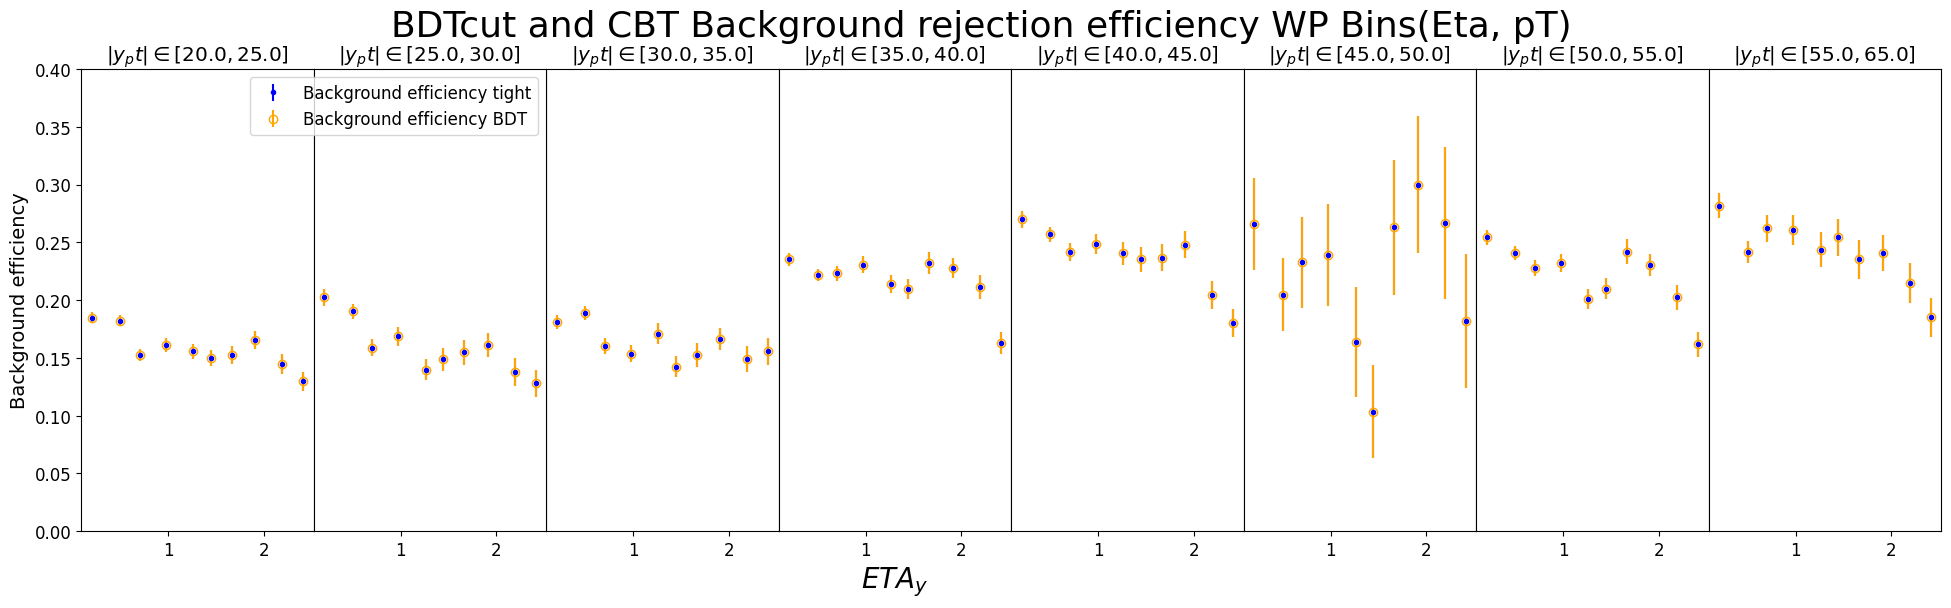

In [26]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(24,6))
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(eta, eff_bkg_tight[i],efferr_bkg_tight[i],
                   fmt=".", label='Background efficiency tight', color = 'blue')
    ax[i].errorbar(eta, eff_bkg_bdt[i],efferr_bkg_bdt[i],
                   fmt="o", fillstyle='none', label='Background efficiency BDT', color = 'orange')    
    #ax[i].set_xscale('log')
    if (i!=0): ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|y_pt| \in [{}, {}]$".format(axis_pt_bkg.edges[i], axis_pt_bkg.edges[i + 1])
    ax[i].set_ylim([0, 0.4])
    ax[i].set(title = text)
    
ax[0].set_ylabel("Background efficiency",  fontsize=14)
ax[3].set_xlabel("$ETA_{y}$",  fontsize=20)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 12)
fig.suptitle('BDTcut and CBT Background rejection efficiency WP Bins(Eta, pT)', fontsize=26)


plt.savefig(savedir+"BDT_PID_reject_effi/BDTcut and CBT Background rejection efficiency WP Bins(Eta, pT).pdf")
plt.show()

In [27]:
print(eta.shape)
print()
print(den_sig.shape)
print()
print(eff_sig_tight.shape)
print()
print(eff_sig_tight[:, 0].shape)
print()
print(eff_sig_tight[0].shape)

(10,)

(10, 41)

(10, 41)

(10,)

(41,)


In [28]:
for i in range(eff_sig_tight.shape[1]):  # Parcourir les colonnes
    print(f"Valeurs de eff_sig_bdt[:, {i}]:")
    print(eff_sig_tight[:, i])
    print()

Valeurs de eff_sig_bdt[:, 0]:
[0.81339713 0.82477726 0.82378472 0.79898089 0.83676642 0.68292683
 0.79609544 0.85271687 0.85765952 0.86486486]

Valeurs de eff_sig_bdt[:, 1]:
[0.85378113 0.84516415 0.84129213 0.81514307 0.84863124 0.67857143
 0.82912234 0.86350148 0.86801596 0.81481481]

Valeurs de eff_sig_bdt[:, 2]:
[0.85394485 0.85768194 0.83916794 0.83946579 0.86556808 0.66
 0.83861051 0.86361186 0.87541781 0.84444444]

Valeurs de eff_sig_bdt[:, 3]:
[0.89004805 0.89694101 0.88031377 0.88134954 0.90071009 0.77887789
 0.89350475 0.90747077 0.9020979  0.8961039 ]

Valeurs de eff_sig_bdt[:, 4]:
[0.89205425 0.90138136 0.89036791 0.88992557 0.8994718  0.7734375
 0.87939959 0.89829146 0.897602   0.88888889]

Valeurs de eff_sig_bdt[:, 5]:
[0.90844562 0.8992104  0.9        0.89947294 0.91356246 0.79899497
 0.8846893  0.89935227 0.90525732 0.91919192]

Valeurs de eff_sig_bdt[:, 6]:
[0.91535508 0.92163948 0.91009636 0.9153516  0.92446616 0.85310734
 0.91501132 0.90193563 0.91570732 0.91489362]


In [29]:
for i in range(eff_sig_bdt.shape[1]):  # Parcourir les colonnes
    print(f"Valeurs de eff_sig_bdt[:, {i}]:")
    print(eff_sig_bdt[:, i])
    print()

Valeurs de eff_sig_bdt[:, 0]:
[0.89244851 0.90623674 0.86631944 0.84917197 0.87524291 0.75609756
 0.87573598 0.91563394 0.93774219 0.97297297]

Valeurs de eff_sig_bdt[:, 1]:
[0.90038839 0.91038154 0.90168539 0.87439858 0.89090177 0.75
 0.90957447 0.92284866 0.93899658 0.85185185]

Valeurs de eff_sig_bdt[:, 2]:
[0.92765493 0.92075472 0.91019787 0.9002453  0.91630529 0.69
 0.90470335 0.95040431 0.94560924 0.95555556]

Valeurs de eff_sig_bdt[:, 3]:
[0.95321194 0.95132314 0.93585526 0.94603366 0.95053869 0.82508251
 0.94713614 0.96407186 0.9633983  0.93506494]

Valeurs de eff_sig_bdt[:, 4]:
[0.95421862 0.93740164 0.94453688 0.94611595 0.94428352 0.83984375
 0.938147   0.96542714 0.96647346 0.96296296]

Valeurs de eff_sig_bdt[:, 5]:
[0.95548604 0.95750116 0.95592841 0.94767965 0.96789463 0.86432161
 0.9401025  0.96038864 0.96629213 0.97979798]

Valeurs de eff_sig_bdt[:, 6]:
[0.96543891 0.96045839 0.96452037 0.96585027 0.96961649 0.92655367
 0.96035538 0.94892724 0.97287805 1.        ]

Vale

In [30]:
for i in range(1):  
    y = [eff_sig_tight[j][i] for j in range(len(eff_sig_tight))]

print(y) 

[0.8133971291866029, 0.824777259227832, 0.8237847222222222, 0.7989808917197452, 0.8367664205207929, 0.6829268292682927, 0.7960954446854663, 0.8527168732125834, 0.8576595195040041, 0.8648648648648649]


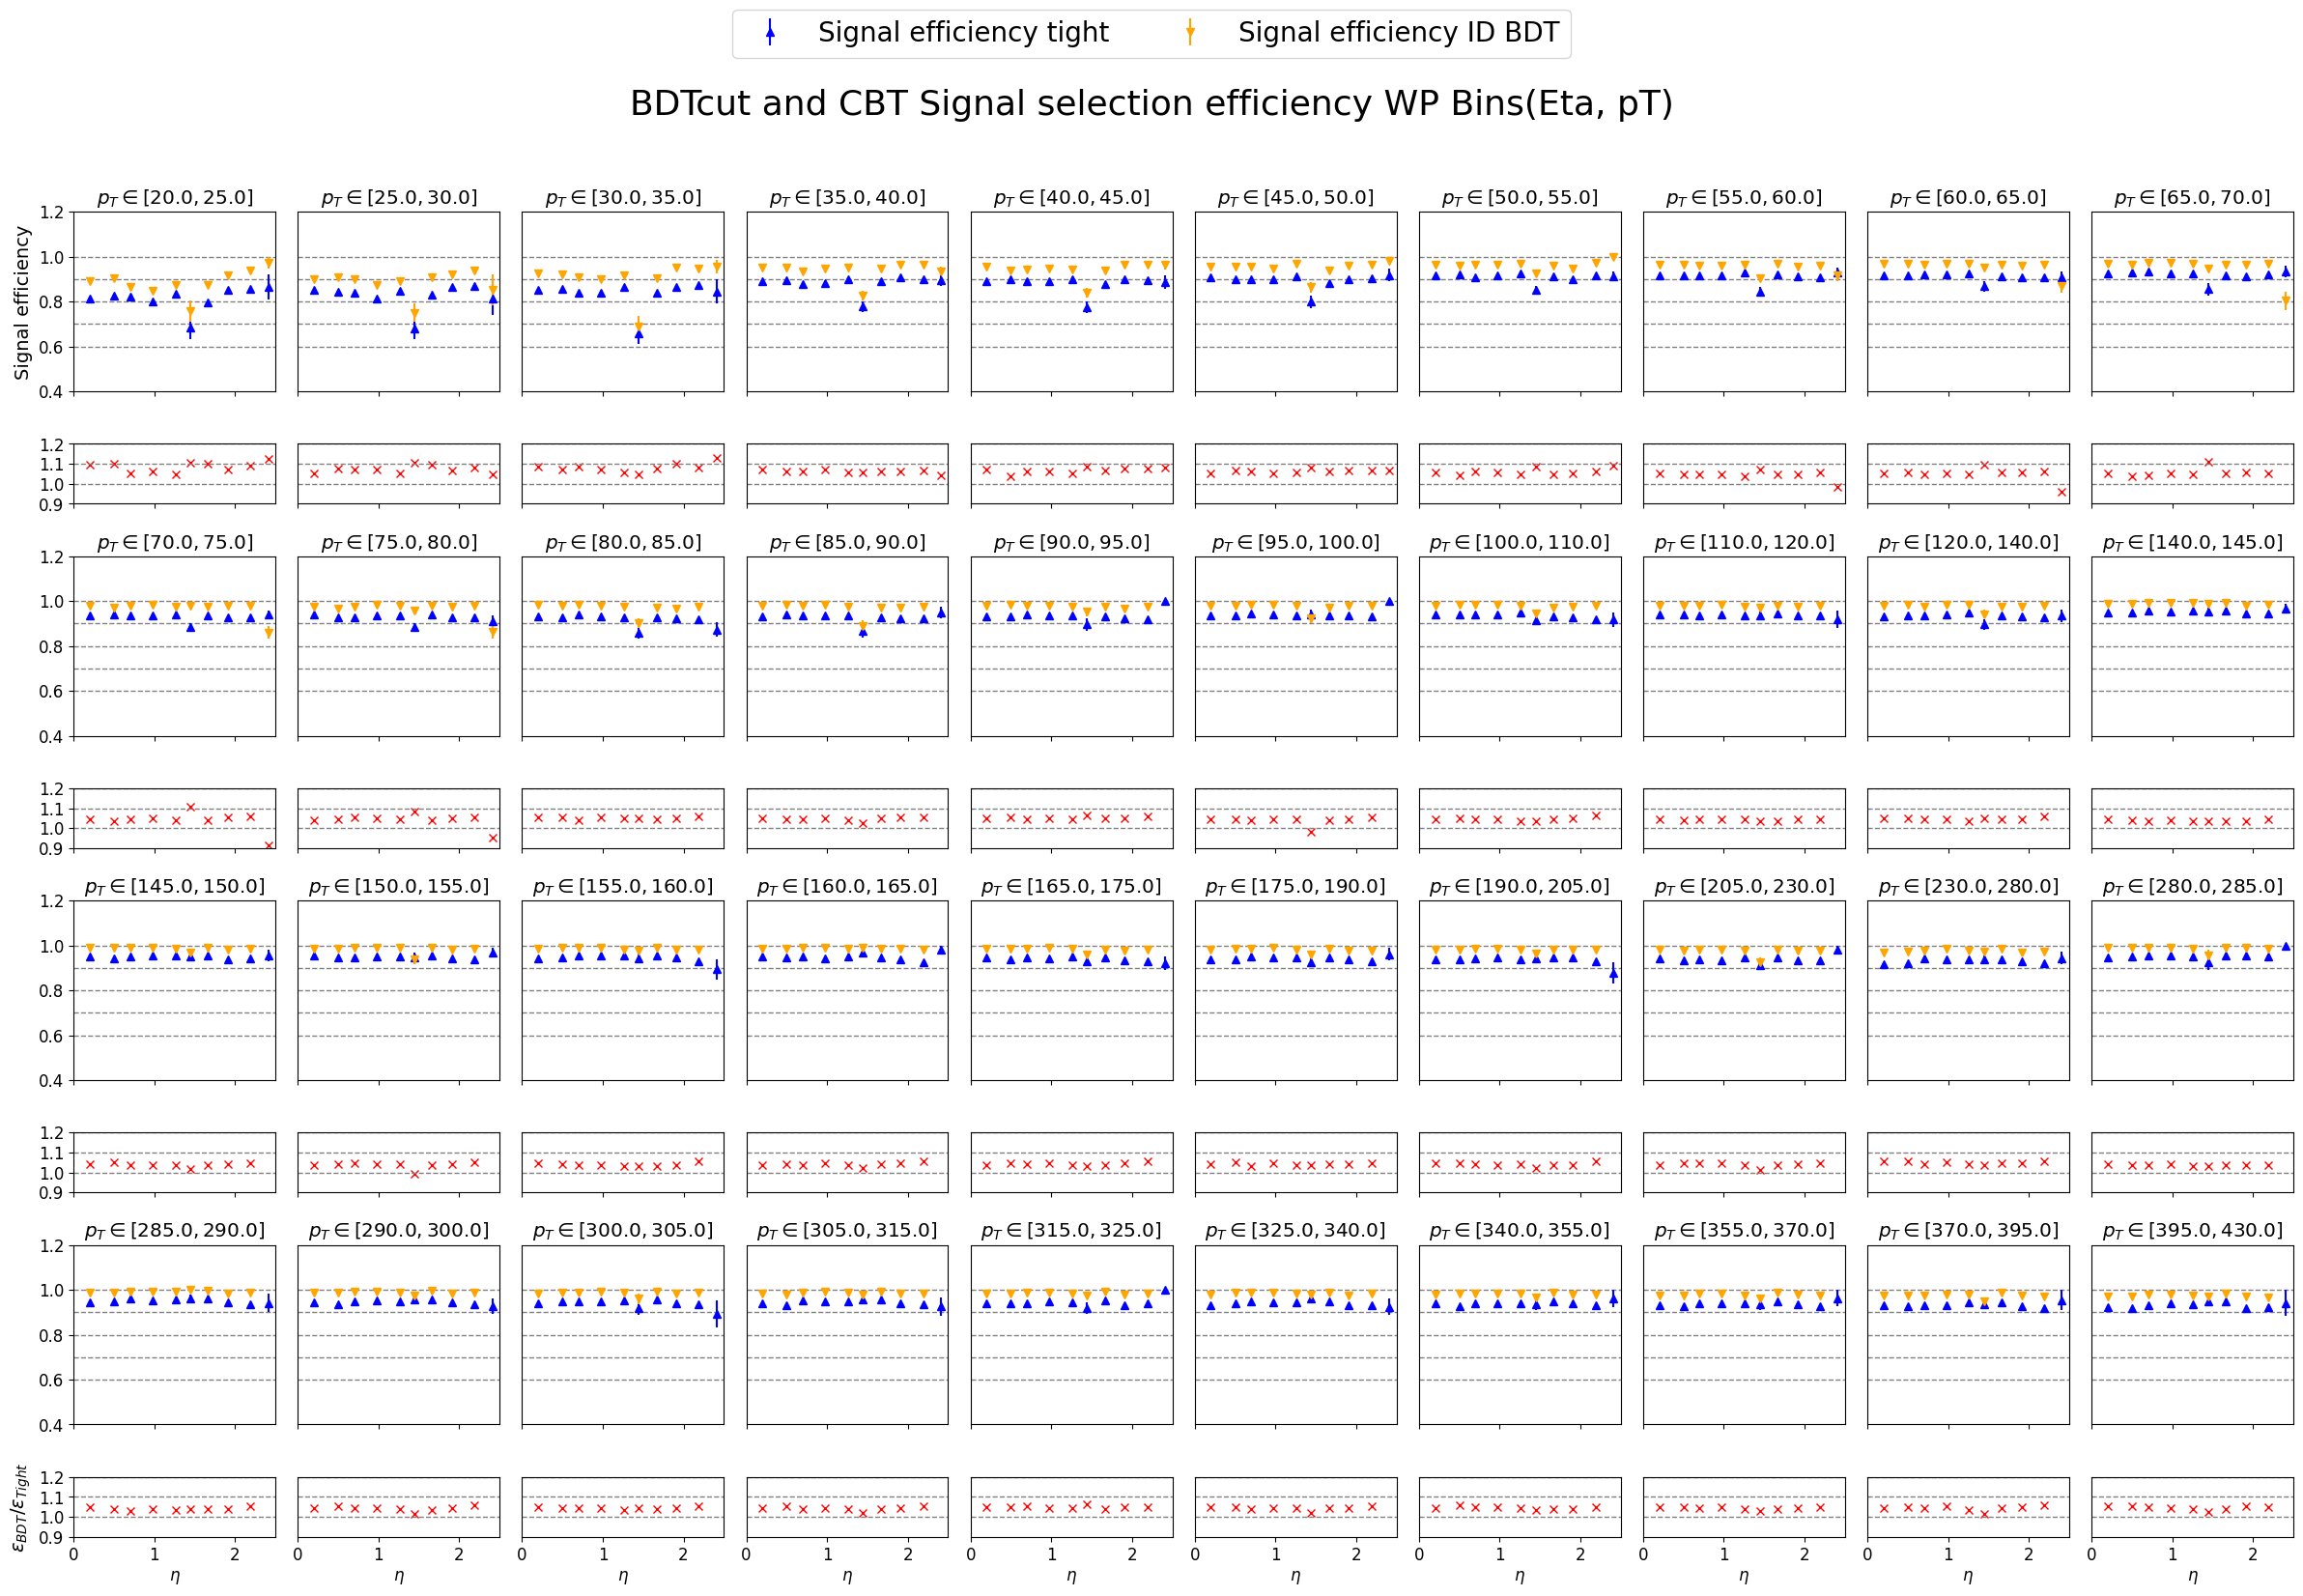

In [31]:
plt.rcParams.update({'font.size': 12})

# Créez une figure avec une grille de subplots
fig, axes = plt.subplots(nrows=8, ncols=10, figsize=(24, 16),
                         gridspec_kw={"height_ratios": [3, 1] * 4}, sharex=True)
fig.subplots_adjust(wspace=0.3, hspace=0.1)

handles = []
labels = []

for i in range(40):
    # Accès à l'axe principal
    ax = axes[i // 10 * 2, i % 10]
    
    # Graphique principal pour l'efficacité
    
    ax.axhline(y=0.6, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=0.7, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=0.8, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=0.9, color='grey', linestyle='--', linewidth=1)
    ax.axhline(y=1.0, color='grey', linestyle='--', linewidth=1)

    errorbar_tight_sig = ax.errorbar(eta, eff_sig_tight[:, i], efferr_sig_tight[:, i],
                                     fmt="^", label='Signal efficiency tight', color='blue')
    errorbar_tight_bkg = ax.errorbar(eta, eff_sig_bdt[:, i], efferr_sig_bdt[:, i],
                                     fmt="v", label='Signal efficiency ID BDT same bkg efficiency', color='orange')

    # Extraction des lignes pour la légende lors du premier subplot
    if i == 0:
        handles.append(errorbar_tight_sig)
        labels.append('Signal efficiency tight')
        handles.append(errorbar_tight_bkg)
        labels.append('Signal efficiency ID BDT')

    # Titre et labels des axes
    ax.set_title(f"$p_T \in [{edges_pt_sig[i]:.1f}, {edges_pt_sig[i+1]:.1f}]$")
    ax.set_ylim(0.4, 1.2)
    ax.set_xlim([0.0, 2.5])
    if i % 10 != 0:
        ax.set_yticks([])

# Accès à l'axe du ratio
    rax = axes[i // 10 * 2 + 1, i % 10]

    # Graphique pour le ratio
    rax.plot(eta, eff_sig_bdt[:, i] / eff_sig_tight[:, i], 'x', color='red')
    rax.axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
    rax.axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
    rax.axhline(y=1.2, color='grey', linestyle='--', linewidth=1)
    rax.set_xlim([0, 2.5])
    rax.set_ylim([0.9, 1.2])
    if i % 10 != 0:
        rax.set_yticks([])

# Étiquettes des axes seulement pour la première colonne
for ax in axes[:, 0]:
    if ax.get_subplotspec().is_first_row():
        ax.set_ylabel("Signal efficiency", fontsize=14)
    elif ax.get_subplotspec().is_last_row():
        ax.set_ylabel(r'$\epsilon_{BDT}$/$\epsilon_{Tight}$', fontsize=14)

# Étiquettes des axes x seulement pour la dernière rangée de subplots
for ax in axes[-1, :]:
    ax.set_xlabel("$\eta$")

fig.suptitle('BDTcut and CBT Signal selection efficiency WP Bins(Eta, pT)', fontsize=26)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=2, fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig(savedir+"BDT_PID_reject_effi/BDTcut and CBT Signal selection efficiency WP Bins(Eta, pT).pdf")
plt.show()

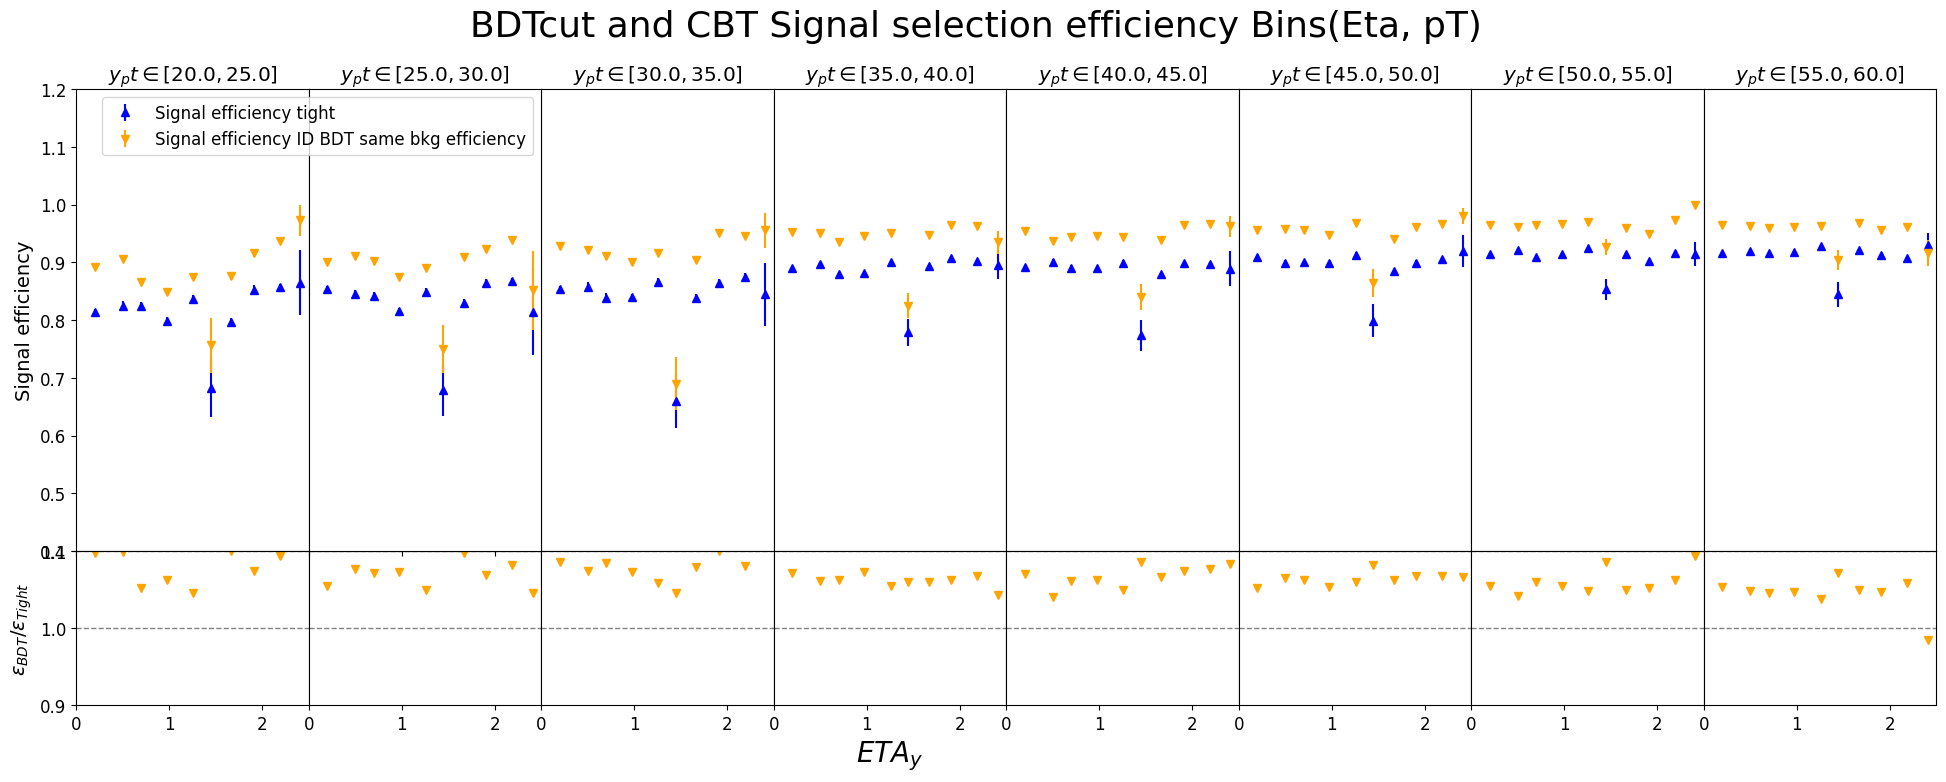

In [32]:
plt.rcParams.update({'font.size': 12})

fig, (ax, rax) = plt.subplots(nrows=2, ncols=8, figsize=(24, 8), 
                              gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(eta, [eff_sig_tight[j][i] for j in range(len(eff_sig_tight))], 
                            [efferr_sig_tight[j][i] for j in range(len(efferr_sig_tight))],
        fmt="^", label='Signal efficiency tight', color = 'blue')
    
    ax[i].errorbar(eta, [eff_sig_bdt[j][i] for j in range(len(eff_sig_bdt))], 
                   [efferr_sig_bdt[j][i] for j in range(len(efferr_sig_bdt))],
        fmt="v", label='Signal efficiency ID BDT same bkg efficiency', color = 'orange')    
    
    #ax[i].set_xscale('log')
    if (i!=0):
        ax[i].set_yticks([])
        
for i in range(8):
    text = r"$y_pt \in [{}, {}]$".format(axis_pt_sig.edges[i], axis_pt_sig.edges[i + 1])
    ax[i].set(title = text)
    rax[i].plot(eta, np.array([eff_sig_bdt[j][i] for j in range(len(eff_sig_bdt))])/np.array([eff_sig_tight[j][i] for j in range(len(eff_sig_tight))]), 
                'v', color = 'orange')
    rax[i].axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=1.2, color='grey', linestyle='--', linewidth=1)
    rax[i].set_xlim([0, 2.5])
    rax[i].set_ylim([0.9, 1.1])
    ax[i].set_ylim([0.4, 1.2])
    if (i!=0):
        rax[i].set_yticks([])
        
rax[0].set_ylabel(r'$\epsilon_{BDT}$/$\epsilon_{Tight}$', fontsize=14)
ax[0].set_ylabel("Signal efficiency",  fontsize=14)
rax[3].set_xlabel("$ETA_{y}$",  fontsize=20)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 12)

fig.suptitle('BDTcut and CBT Signal selection efficiency Bins(Eta, pT)', fontsize=26)


#plt.savefig(savedir+"BDT_PID_reject_effi/BDT_PID_efficiency_ETA_Bin_pT.pdf")
plt.show()